# Predictor Data Normalization & Noiseification

In [1]:
import networkx as nx
from networkx.algorithms.link_prediction import jaccard_coefficient

import random

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split

from concurrent.futures import ProcessPoolExecutor

import copy

## Import the Raw Predictor Scores

In [2]:
# Retrieve data 
with open('02-predictor-data/raw/predictors.pkl', 'rb') as f:
    predictors = pickle.load(f)
    
jacc_edge_scores = predictors[0]
adamic_adar_edge_scores = predictors[1]
geodesic_edge_scores = predictors[2]
common_neighbors_edge_scores = predictors[3]
degree_prod_edge_scores = predictors[4]
baseline_edge_scores = predictors[5]

print('Data shape:', predictors[0][0].shape)

Data shape: (382060, 1)


In [3]:
# Predictor names
predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product', 'Baseline']

# Sanity check for predictors: Find highest and lowest scores
for i, predictor in enumerate(predictors):
    all_scores = np.concatenate(predictor)  # Flatten all graphs' scores into one array
    max_score = np.max(all_scores)
    min_score = np.min(all_scores)
    print(f'Predictor: {predictor_names[i]}')
    print(f'  Max score: {max_score}')
    print(f'  Min score: {min_score}')
    print('-' * 40)

Predictor: Jaccard Coefficient
  Max score: 1.0
  Min score: 0.0
----------------------------------------
Predictor: Adamic-Adar Index
  Max score: 35.633264420546055
  Min score: 0.0
----------------------------------------
Predictor: Geodesic Distance
  Max score: 16
  Min score: 0
----------------------------------------
Predictor: Common Neighbors
  Max score: 51
  Min score: 0
----------------------------------------
Predictor: Degree Product
  Max score: 19824
  Min score: 1
----------------------------------------
Predictor: Baseline
  Max score: 0.9999993663479336
  Min score: 1.3326382886091892e-08
----------------------------------------


## Add Noise to Data

In [4]:
p = 0
g = 0
e = 5
print('Sample edge prediction before noise:', predictors[p][g][e])


def add_noise(predictors):
    small_val = 1e-10 # This value should be small enough

    for i in range(len(predictors)): # On each predictor
        for j in range(len(predictors[i])): # On each graph's edge predictions
            G = predictors[i][j]
            noise = np.random.uniform(0,small_val,G.shape) # Add random noise to each edge
            predictors[i][j] = G + noise

    return predictors



predictors = add_noise(predictors)   
 
print('Sample edge prediction after noise:', predictors[p][g][e])

print('Data shape:', predictors[0][0].shape)

Sample edge prediction before noise: [0.]
Sample edge prediction after noise: [8.06527422e-11]
Data shape: (382060, 1)


In [5]:
# Sanity check


# Predictor names
predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product', 'Baseline']

# Sanity check for predictors: Find highest and lowest scores
for i, predictor in enumerate(predictors):
    all_scores = np.concatenate(predictor)  # Flatten all graphs' scores into one array
    max_score = np.max(all_scores)
    min_score = np.min(all_scores)
    print(f'Predictor: {predictor_names[i]}')
    print(f'  Max score: {max_score}')
    print(f'  Min score: {min_score}')
    print('-' * 40)

Predictor: Jaccard Coefficient
  Max score: 1.0000000000999631
  Min score: 1.3459456515985125e-17
----------------------------------------
Predictor: Adamic-Adar Index
  Max score: 35.633264420608846
  Min score: 2.4350845861942363e-17
----------------------------------------
Predictor: Geodesic Distance
  Max score: 16.000000000028052
  Min score: 7.26407975648602e-16
----------------------------------------
Predictor: Common Neighbors
  Max score: 51.000000000072745
  Min score: 6.463928379218942e-17
----------------------------------------
Predictor: Degree Product
  Max score: 19824.000000000047
  Min score: 1.0000000000000004
----------------------------------------
Predictor: Baseline
  Max score: 0.9999993663547578
  Min score: 1.3393038950992216e-08
----------------------------------------


## Normalize Data

small_val = 1e-10 # This value should be small enough

Later down the line, we will make an AUC curve of the models predictions. The predictions it makes will be 1 predictor (which it selects) for each edge. Therefore all the predictors need to be on the same scale for consistent comparison.

We need each predictor to have its highest values scaled so they are close to 1 and its lowest values scaled so they are close to 0. With that in mind we need to invert the scores of geodesic distnace since it's our only predictor where a larger score means a smaller likleyhood of two nodes sharing an edge



In [6]:
def normalize_predictors(predictors):
    predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product', 'Baseline']
    for i, predictor in enumerate(predictors):
        for g, graph_scores in enumerate(predictor):
            if predictor_names[i] == "Jaccard Coefficient":
                predictors[i][g] = (graph_scores - graph_scores.min()) / (graph_scores.max() - graph_scores.min())
            elif predictor_names[i] == "Adamic-Adar Index":
                predictors[i][g] = np.log(1 + graph_scores) / np.log(1 + graph_scores.max())
            elif predictor_names[i] == "Geodesic Distance":
                predictors[i][g] = 1 / (1 + graph_scores)
            elif predictor_names[i] == "Common Neighbors":
                predictors[i][g] = np.log(1 + graph_scores) / np.log(1 + graph_scores.max())
            elif predictor_names[i] == "Degree Product":
                predictors[i][g] = np.log(1 + graph_scores) / np.log(1 + graph_scores.max())
            elif predictor_names[i] == "Baseline":
                predictors[i][g] = (graph_scores - graph_scores.min()) / (graph_scores.max() - graph_scores.min())

    return predictors


predictors = normalize_predictors(predictors)

## Sanity check for outliars

In [7]:
# Predictor names
predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product', 'Baseline']

# Sanity check for predictors: Find highest and lowest scores
for i, predictor in enumerate(predictors):
    all_scores = np.concatenate(predictor)  # Flatten all graphs' scores into one array
    max_score = np.max(all_scores)
    min_score = np.min(all_scores)
    print(f'Predictor: {predictor_names[i]}')
    print(f'  Max score: {max_score}')
    print(f'  Min score: {min_score}')
    print('-' * 40)

Predictor: Jaccard Coefficient
  Max score: 1.0
  Min score: 0.0
----------------------------------------
Predictor: Adamic-Adar Index
  Max score: 1.0
  Min score: 0.0
----------------------------------------
Predictor: Geodesic Distance
  Max score: 0.9999999999999993
  Min score: 0.05882352941166764
----------------------------------------
Predictor: Common Neighbors
  Max score: 1.0
  Min score: 0.0
----------------------------------------
Predictor: Degree Product
  Max score: 1.0
  Min score: 0.07005237625745932
----------------------------------------
Predictor: Baseline
  Max score: 1.0
  Min score: 0.0
----------------------------------------


In [8]:
# Sanity check, check shape of predictors
predictors[0][0].shape

(382060, 1)

# Save the Data

In [9]:
predictors = copy.deepcopy([jacc_edge_scores, adamic_adar_edge_scores, geodesic_edge_scores, 
              common_neighbors_edge_scores, degree_prod_edge_scores, 
             baseline_edge_scores])

# Save data 
with open('03-normalized-data/predictors.pkl', 'wb') as f:
    pickle.dump(predictors, f)


# Explore the Data

In [10]:
# Copy data
# (So I can run these cellsmultiple times and not run all cells from the beginning!)
predictors = copy.deepcopy([jacc_edge_scores, adamic_adar_edge_scores, geodesic_edge_scores, 
              common_neighbors_edge_scores, degree_prod_edge_scores, 
             baseline_edge_scores])

In [11]:
'''
Up until here I've been writing things in my own code
I have just realized that we dont need to submit any code for this final project :)
Given than I am very confident in python, data analysis and machine learning,
I am going to start using chat gpt super heavily!!!
This should accelerate the progress of the project a lot
Also I'd guess I'm going to run into some crazy bumps later.
So it totally makes sense I do this to more rapidly expirament!

Cheers!
'''

"\nUp until here I've been writing things in my own code\nI have just realized that we dont need to submit any code for this final project :)\nGiven than I am very confident in python, data analysis and machine learning,\nI am going to start using chat gpt super heavily!!!\nThis should accelerate the progress of the project a lot\nAlso I'd guess I'm going to run into some crazy bumps later.\nSo it totally makes sense I do this to more rapidly expirament!\n\nCheers!\n"

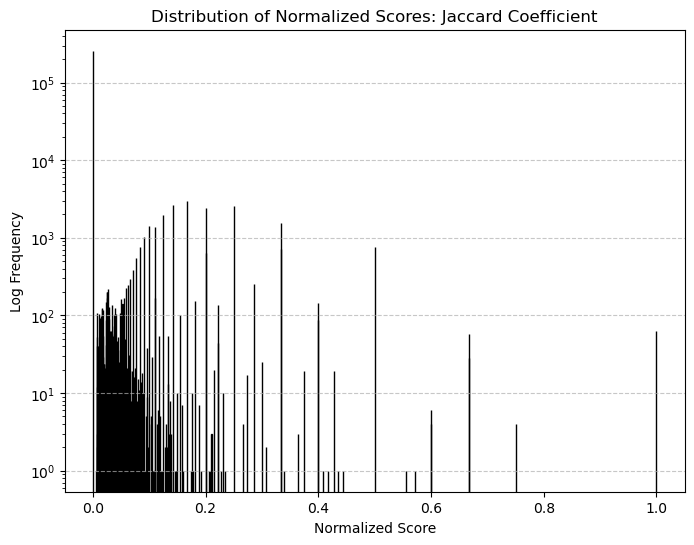

KeyboardInterrupt: 

In [12]:
# Predictor names for labeling
predictor_names = ['Jaccard Coefficient', 'Adamic-Adar Index', 'Geodesic Distance',
                   'Common Neighbors', 'Degree Product', 'Baseline']

'''
# Generate bar plots for each predictor
for i, predictor in enumerate(predictors):
    # Pick a random graph for this predictor
    random_graph = random.choice(predictor)  # Select a random graph's scores

    # Normalize the scores to scale them between 0 and 1
    min_val = np.min(random_graph)
    max_val = np.max(random_graph)
    if max_val > min_val:
        normalized_scores = (random_graph - min_val) / (max_val - min_val)
    else:
        normalized_scores = random_graph  # If all values are the same, no normalization needed

    # Dynamically determine the number of bins based on the normalized data size
    num_bins = max(50, len(normalized_scores) // 10)  # At least 50 bins or 1/10th of the data size
    
    # Plot histogram with many bins and set logarithmic scaling on both x-axis and y-axis
    plt.figure(figsize=(8, 6))
    plt.hist(normalized_scores, bins=np.logspace(np.log10(1e-4), 0, num_bins), edgecolor='black', log=True)
    
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.title(f'Distribution of Normalized Scores (Log-Log Scale): {predictor_names[i]}')
    plt.xlabel('Normalized Score (Log Scale, 0-1)')
    plt.ylabel('Log Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set custom x-ticks for better readability
    plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1], ["0.0001", "0.001", "0.01", "0.1", "1"])
    
    plt.show()


    '''
    # Generate bar plots for each predictor
for i, predictor in enumerate(predictors):
    # Pick a random graph for this predictor
    random_graph = random.choice(predictor)  # Select a random graph's scores

    # Normalize the scores to scale them between 0 and 1
    min_val = np.min(random_graph)
    max_val = np.max(random_graph)
    if max_val > min_val:
        normalized_scores = (random_graph - min_val) / (max_val - min_val)
    else:
        normalized_scores = random_graph  # If all values are the same, no normalization needed

    # Dynamically determine the number of bins based on the normalized data size
    num_bins = max(50, len(normalized_scores) // 10)  # At least 50 bins or 1/10th of the data size
    
    # Plot histogram with many bins and logarithmic scaling on y-axis
    plt.figure(figsize=(8, 6))
    plt.hist(normalized_scores, bins=num_bins, edgecolor='black', log=True)
    
    plt.title(f'Distribution of Normalized Scores: {predictor_names[i]}')
    plt.xlabel('Normalized Score')
    plt.ylabel('Log Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    